# MesaNet

MesaNet is a novel architecture for sequence modeling that aims to overcome the linear scaling memory and compute requirements of traditional causal transformer architectures during inference. It introduces a Mesa layer, which is a numerically stable, chunkwise parallelizable recurrent neural network (RNN) layer.

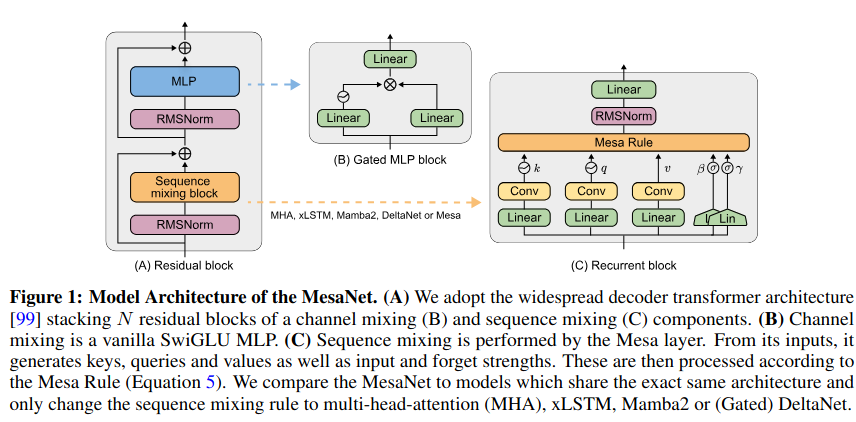

The key features of MesaNet:

**Optimal Test-Time Training**:

Unlike other RNNs that approximate an in-context regression objective through online learning rules (like gradient descent), the Mesa layer minimizes an in-context loss function to optimality at every time point. This allows it to retain past information and adapt to new evidence quickly as a sequence unfolds.

It defines the linear map (Φ<sub>t</sub>) as the solution to a cumulative regularized squared-error loss, taking into account all data seen so far (e1:t).

This optimization problem is solved using a fast Conjugate Gradient (CG) solver for a linear system of equations (linsolve(H<sub>h,t</sub> + Λ<sub>h</sub>, q<sub>h,t</sub>)), where H<sub>h,t</sub> is a state variable maintained through a linear recurrence, representing an accumulation of past key-key outer products; Λ<sub>h</sub> - regularization parameter, q<sub>h,t</sub> - query vector for head h at time t. E.g. at each step a linear system of equations is solved to find optimal q<sub>t</sub><sup>*</sup>

**Recurrent Neural Network (RNN) with Constant Complexity**:

MesaNet is part of a stream of work on RNN models that achieve constant memory and compute costs during inference, a significant advantage over Transformers, especially for autoregressive tasks like language modeling.

It processes sequences by representing and learning a linear model in its activations, similar to "fast weight programming layers".

**Chunkwise Parallelizable Design**:

The Mesa layer is designed to be parallelizable over sequence length, allowing for efficient training by leveraging matrix multiplication accelerators like GPUs and TPUs. This is achieved by exploiting an equivalence of the CG method over multiple time steps with gated linear self-attention.

**Dynamic Test-Time Compute Allocation**:

A significant feature is its ability to dynamically adapt its computational cost at test time based on the sequence being processed.

The number of CG steps required to reach a desired error tolerance (ϵ) is generally head-, sequence-, and token-specific, allowing the Mesa layer to exhibit dynamic inference costs. This means it can trade off test-time compute for performance. For example, using a dynamic stopping criterion of ϵ = 10^-4 can achieve performance on par with a fixed 30 CG steps, while reducing the average CG steps to approximately 9.

**Mesa Rule, optimization problem**:

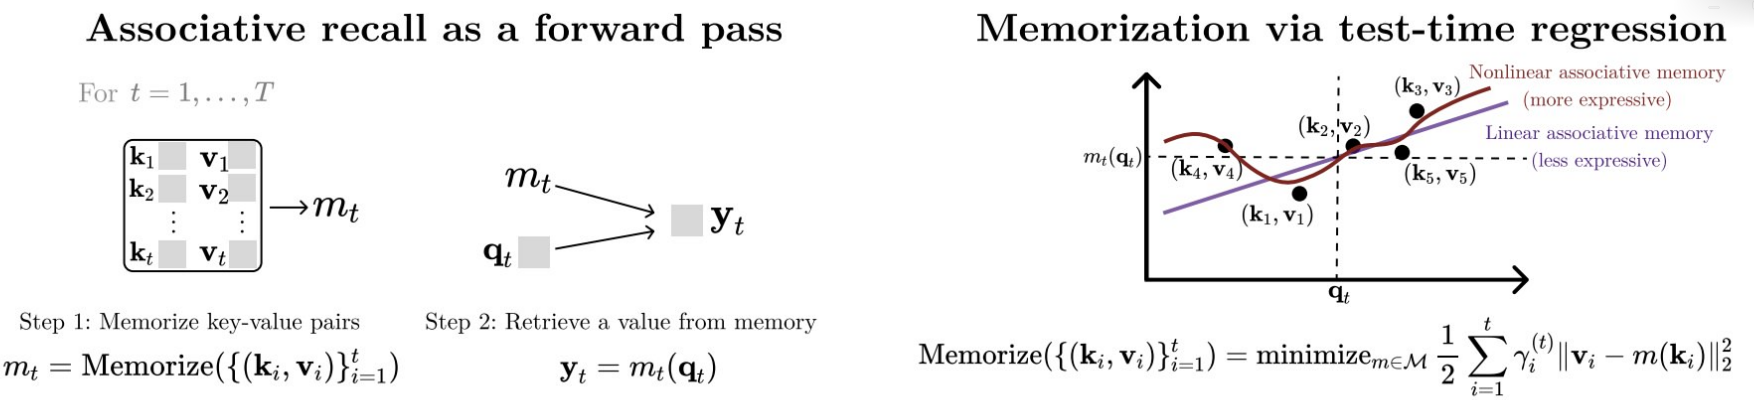

Mesa layer updates tokens according to the linear self-attention rule 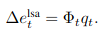 (∆e<sub>t</sub><sup>lsa</sup> - output embedding of linear self-attention, q<sub>t</sub> - query embedding) but now defines
the linear map Φ<sub>t</sub> as the solution of a test-time optimization problem, where Λ plays the role of
a quadratic regularizer:

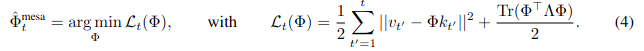

Instead of considering an instantaneous loss measured only at the current input e<sub>t</sub>, the Mesa layer optimizes the cumulative regularized squared-error loss taking into account all data e<sub>1:t</sub> so far. While at first this may seem impossible to achieve under a constant memory requirement, the Mesa layer circumvents the need to explicitly keep past tokens in memory (as in softmax self-attention) and exploits the fact that L<sub>t</sub> is a quadratic function of Φ. Second, instead of taking a single gradient descent step, the Mesa layer learns Φ to optimality at every time point.

But this original version of the layer is not parallelizable, and it therefore heavily underutilizes current matrix-matrix multiplication accelerators such as GPUs and TPUs during training.

**Mesa Rule, the solution**:
    
So, in practice, Mesa layer output (∆emesa t) is computed by summing over multiple heads, each involving a linsolve operation: 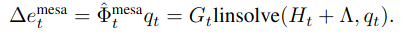

It maintains two crucial state variables, G<sub>h,t</sub> and <sub>h,t</sub>, which are updated using linear recurrence relations involving forget gates (γh,t) and input gates (βh,t):

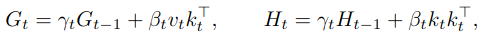

v<sub>t</sub> - values vector at time t, k<sub>t</sub> - key vector at time t

Input and forget gates (β<sub>t</sub>, γ<sub>t</sub>) are functions of the current input and are bounded within to improve performance. The forget gate γ<sub>t</sub> is upper-bounded (e.g., 0.9975) and adjusted based on input strength for numerical stability.

Regularization parameters (Λ<sub>h</sub>) are applied to the linear system and are passed through a softplus function to ensure positivity. These parameters are generally fixed over time and lower-bounded (e.g., 0.25) to control the condition number.

Input embeddings undergo RMS Normalization. Keys (k<sub>t</sub>), queries (q<sub>t</sub>), and values (v<sub>t</sub>) are generated via linear projections, convolved in time, and then keys and queries are L2-normalized after a SiLU non-linearity.

**Performance on Benchmarks**:

Synthetic Tasks: MesaNet excels at synthetic tasks like RegBench and MAD, outperforming other linear transformer alternatives and performing on par with Transformers on RegBench.

Language Modeling: MesaNet and its hybrid variant, Hawk-MesaNet, achieve lower validation perplexity on the SlimPajama dataset compared to other RNN models like Mamba2, xLSTM, and DeltaNet, and can match or even surpass Transformer baselines in average per-token perplexity.

Context Understanding: It shows strong performance early in sequences and extends its advantage in language modeling beyond 512 tokens compared to other recurrent models. On global downstream benchmarks requiring longer contexts, MesaNet outperforms other recurrent models, though it might still underperform the transformer baseline.

In-Context Recall: MesaNet generally outperforms other recurrent models and even exceeds SWA-1024, but a gap remains with Transformer baselines.

Few-Shot Learning: It demonstrates strong performance on word scrambling tasks, often outperforming the Transformer, but typically fails to match Transformer performance on translation tasks.

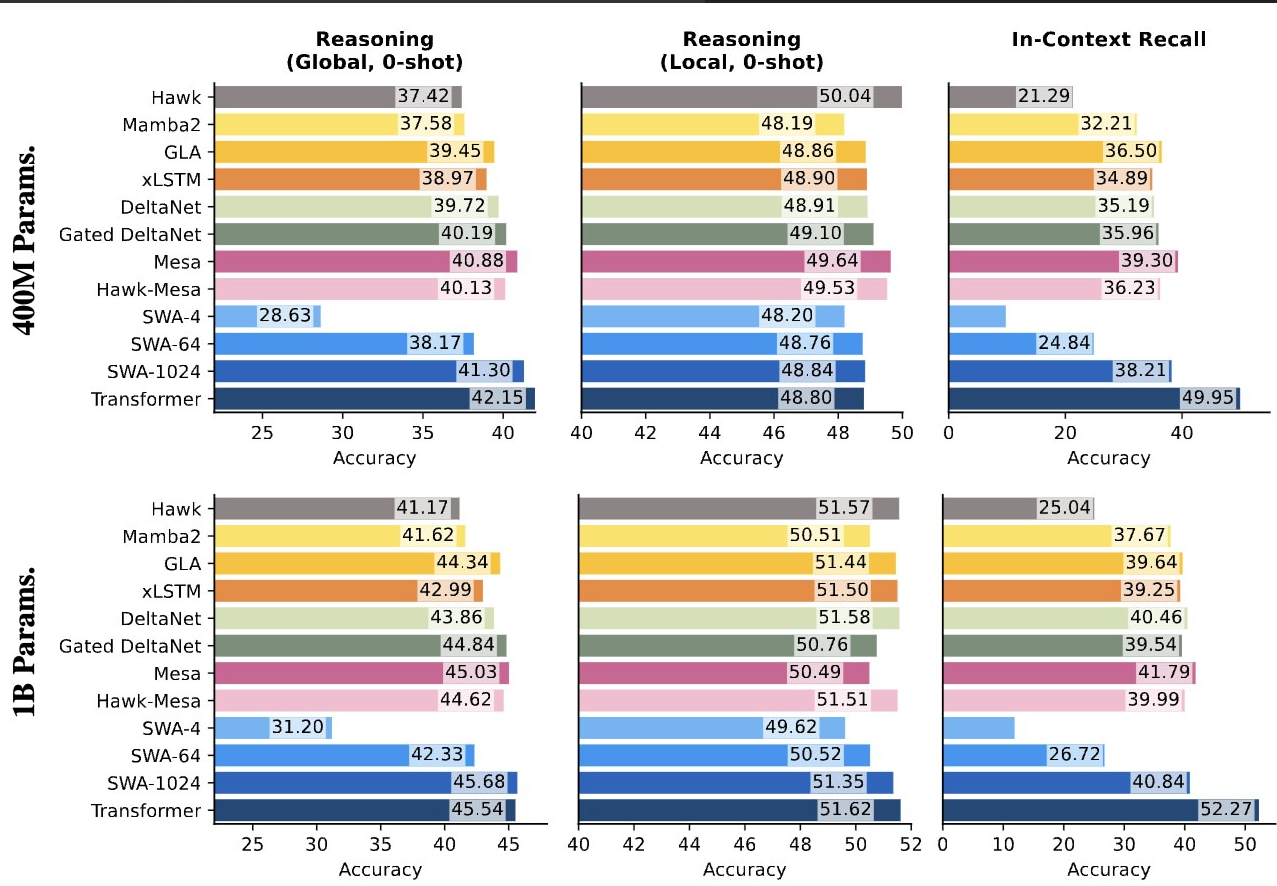

# Mixture-of-Recursions (MoR)

Main idea: recursion transformer, where every token passes through layer not only one time - at the output of the layer there is a router which can turn back the token and make it pass this layer one more time and then again up to 𝑁𝑟 times.

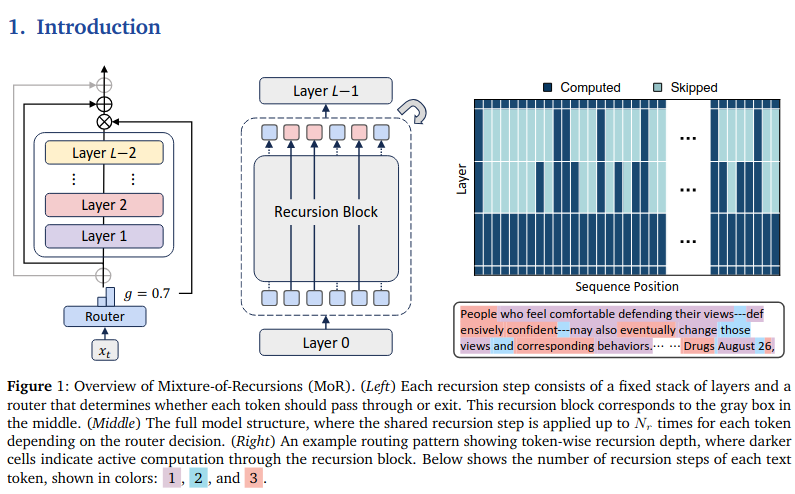

## Routing Mechanism
 
This mechanism dynamically assigns different recursion depths to individual tokens, allowing the model to focus computational resources where they are most needed.

There are two types of routing

### Parameter-sharing strategies

There are four parameter-sharing strategies: *Cycle*, *Sequence*, and their variants *Middle-Cycle* and *Middle-Sequence*

In Cycle sharing, recursion blocks are reused cyclically. For example, consider an original non-recursive model with 𝐿=9 layers and its recursive counterpart using 𝑁𝑟 =3 recursions. Under the “Cycle” strategy, the layers are shared and unrolled as [(0, 1, 2), (0, 1, 2), (0, 1, 2)]. In “Sequence” sharing, each recursion block reuses the same layer consecutively before moving to the next, resulting in [(0, 0, 0), (1, 1, 1), (2, 2, 2)] for the same configuration. Both have the same effective number of layers when unrolled (𝐿=9), but with a different order. The “Middle” variants preserve full-capacity parameters at the first and last layers (Φ<sub>0</sub> and Φ<sub>𝐿−1</sub>), while sharing weights among the intermediate layers.

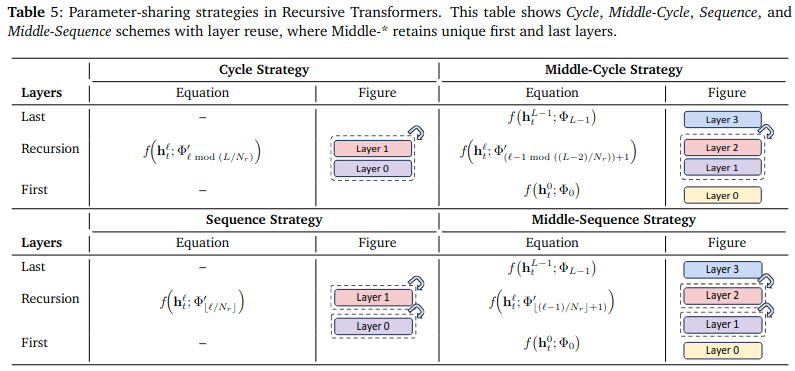

Cycle sharing generally demonstrates superior performance compared to pure Sequence sharing. Middle-Cycle is consistently the most effective parameter sharing strategy overall.

### Expert-choice routing (Figure 2a)

Involves a router at each recursion step selecting a top-𝑘 subset of tokens to continue processing, progressively narrowing the set of active tokens as depth increases. This strategy guarantees perfect load balancing but can suffer from causality violation during training, which is mitigated by auxiliary routers or auxiliary loss

### Token-choice routing (Figure 2b)

Commits each token to a fixed number of recursion blocks from the outset based on a single routing decision. This avoids causality issues but can lead to load imbalance, requiring balancing losses or loss-free algorithms for mitigation.

## KV Caching Strategies

MoR models are designed with tailored Key-Value (KV) caching strategies to address the challenge of KV cache consistency and memory footprint in dynamic-depth models.

### Recursion-wise KV caching (Figure 2c–Top)

Selectively stores KV pairs only for tokens routed to a given recursion step, restricting attention to these locally cached tokens. This reduces KV cache size, improves memory efficiency, and decreases I/O demands.

### Recursive KV sharing (Figure 2c–Bottom)

Reuses KV pairs from the first recursion step across all subsequent recursions, achieving maximal memory savings and speeding up prefill operations. However, it may lead to performance degradation in expert-choice routing due to potential context mismatches

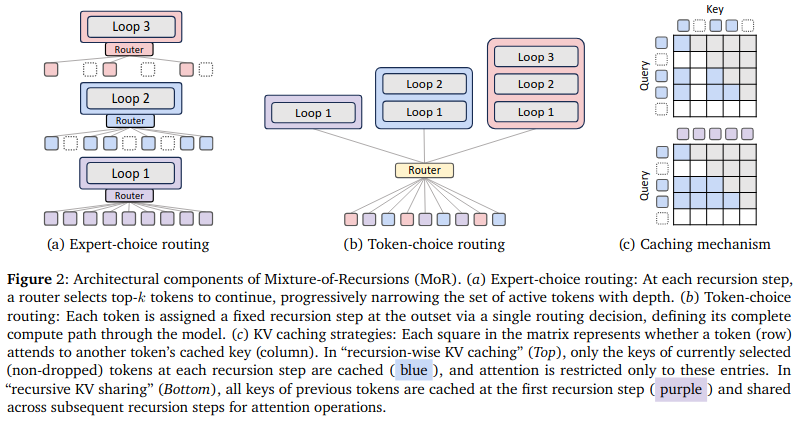

## Comparsion of routing and KV caching strategies

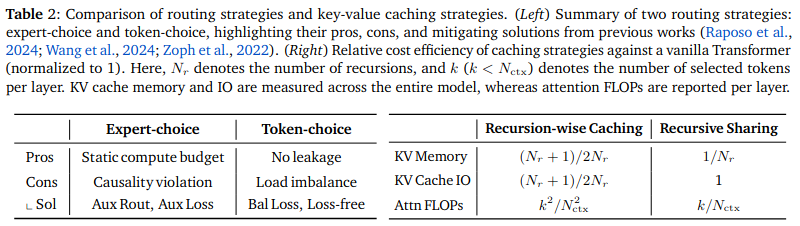

## Improved Performance
 
Across model scales from 135M to 1.7B parameters, MoR sets a new Pareto frontier by significantly lowering validation perplexity and improving few-shot accuracy compared to vanilla and existing recursive baselines, often with smaller model sizes and equal training FLOPs. For example, MoR can achieve superior performance with nearly 50% fewer parameters under the same FLOPs budget, or with 25% fewer training FLOPs at equal data.

## Experiments

MoR models with expert-choice routing (specifically with auxiliary loss and a linear router) and recursion-wise KV caching offer the most advantageous combination. 

While recursive KV sharing offers the advantages of reduced memory footprint and overall FLOPs5, it leads to quite large
performance degradation in expert-choice routing under a fixed token setting. So, recursion-wise KV caching is the recommended choice with expert-choice routing.

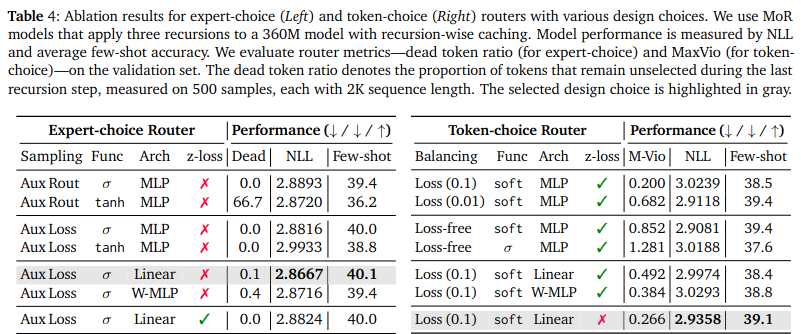

# Efficient Architectures for Large Language Models

Main article:

https://arxiv.org/pdf/2508.09834

## Linear Sequence Modeling

### Linear Attention

See also: *Transformers and Language models part 1 -> Effective transformers -> Linear Transformer*

Main idea: replace the standard softmax attention with a linear approximation based on feature maps or kernel functions. This modification addresses the computational inefficiencies of conventional attention mechanisms and enables linear-time
complexity. The generalized form of attention using an arbitrary similarity function can be expressed as:

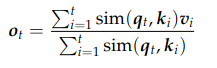

Where sim is similarity function and q, k and v are query, key and value embeddings. In vanilla transformer sim(q, k) = exp(qk<sup>T</sup>). Linear attention introduces kernel-based function to represent sim(q, k) as ϕ(q)ϕ(k)<sup>T</sup>

Then Equation above can be rewritten as:

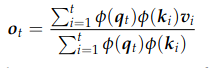

And can be further simplified to:

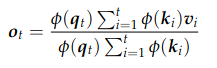

Then:

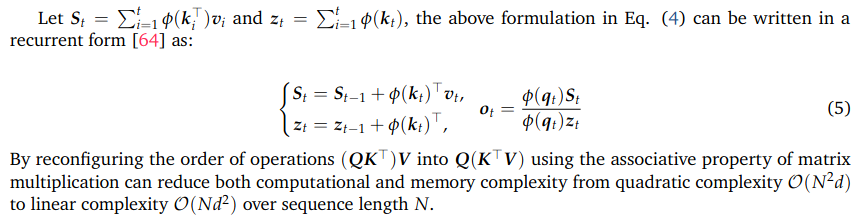



### Linear RNN

Main idea: remove nonlinearity from RNN because Traditional RNNs unalbe conduct parallel training and have low efficiency because update of hidden state involves matrix multiplication and nonlinear activation functions which not only leads to gradient issues but also prevents parallel training. 

Vanilla RNN formula is:



Where h<sub>t-1</sub> - previous hidden state, f() - projection function and σ() - activation function.

Typical Linear RNN is formulated as follows:

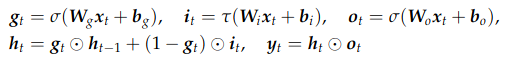

 - element-wise product

Since linear RNN removes nonlinearity, it enables efficient parallelized training and achieve linear recurrent inference for sequence modeling.

### State Space Model (SSM)

See: *Transformers and Language models part 2 -> Effective transformers -> Hybrid H3, SSM, Mamba*